# Energy buff

In [1]:
# Definering av funksjoner og importering av bibiliotek
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Finner kapasietsleddkostnad basert på kapasitetsleddnivå
def findCapacityPrice(consumptionList, capacityList):
    capacity = 0
    for j in consumptionList:
        if j > capacity:
            capacity = j
    newLink = getCapacityLink(capacity)
    newPrice = capacityList[newLink]
    return newPrice


# Definerer konstanter
evenMonth = [4, 6, 9, 11]
oddMonth = [1, 3, 5, 7, 8, 10, 12]
flag = 0

# Liste som beskriver forbruk over dagen per time
normalConsumptionPercent = [        0.068775791, 0.055020633, 0.056396149, 0.057771664,
                                    0.05914718, 0.027510316, 0.023383769, 0.024759285,
                                    0.03301238, 0.068775791, 0.057771664, 0.037138927,
                                    0.024759285, 0.031636864, 0.031636864, 0.034387895,
                                    0.020632737, 0.038514443, 0.068775791, 0.03301238,
                                    0.034387895,0.037138927,0.034387895,0.041265475 ]

# Liste som beskriver forbruk over dagen per time med Energy buff sin batteripakke
normalConsumptionWBatteryPercent = [0.06232687, 0.06232687, 0.06232687, 0.06232687,
                                    0.06232687, 0.06232687, 0.0, 0.0,
                                    0.0, 0.0, 0.009695291, 0.06232687,
                                    0.06232687, 0.06232687, 0.06232687, 0.06232687,
                                    0.041551247, 0.041551247, 0.027700831, 0.013850416,
                                    0.013850416,0.055401662,0.055401662,0.06232687 ]

# Liste med priser ppå alle kapasitetsleddnivå
capacityLinkList = [                168.75, 281.25,
                                    462.50, 822.50,
                                    1092.50, 1355.00,
                                    2100.00, 3287.50,
                                    4475.00, 7252.50]

fileName = "strom_til_27_02_23.csv"

ImportError: cannot import name 'checkMonth' from 'functions' (/home/peder/GitHub/INGT2300/functions.py)

Visualisering av hvordan appen kommer til å se ut

Sett inn hvor i Norge du bor:
- NO1 = Oslo / Øst-Norge
- NO2 = Kristiansand / Sør-Norge
- NO3 = Trondheim / Midt-Norge
- NO4 = Tromsø / Nord-Norge
- NO5 = Bergen / Vest-Norge

In [2]:
# Bruker input
priceArea = "NO1"
yearlyConsumption = 72*365
capacityLink = 3

# Beregninger
dailyConsumption = yearlyConsumption / 365
normalConsumption = [i * dailyConsumption for i in normalConsumptionPercent]
normalConsumptionWBattery = [i * dailyConsumption for i in normalConsumptionWBatteryPercent]


# Verdier for simulering
startDate = 1
startMonth = 1
startYear = 2022
days = 50

date = startDate
month = startMonth
year = startYear
elapsedMonths = 0

for i in range(0,days):
    strDate = makeStr(date)
    strMonth = makeStr(month)
    # Bygger link for å hente data
    link = "https://www.hvakosterstrommen.no/api/v1/prices/" + str(year) + "/" + strMonth + "-" + strDate + "_" + priceArea + ".json"
    # Henter data
    response = requests.get(link).text
    df = pd.read_json(response)
    # Rydder data 
    df = df.drop(['EXR', 'EUR_per_kWh','time_end'], axis=1)

    # Når nasjonen bytter tidssone blir det kluss fordi vi ikke får de forventede 24 tastene 
    # Tar da et gjennomsnitt av 23 datapunkt og legger det inn for sommertid
    # For vinterstid tar vi vekk det 3. tast i døgnet
    if len(df.index) < 24:
        missing = 24 - len(df.index)
        avg = df['NOK_per_kWh'].sum()/len(df.index)
        for i in range(missing):
            df.loc[len(df.index)] = [avg, 0]
    elif len(df.index) == 25:
       df.drop(3, axis=0, inplace=True)

    # Legger på kolonner
    df['consumption'] = normalConsumption
    df['consumption_cost'] = df['consumption']*df['NOK_per_kWh']
    df['consumption_with_battery'] = normalConsumptionWBattery
    df['consumption_cost_with_battery'] = df['consumption_with_battery']*df['NOK_per_kWh']

    # Fjerner øverste beskrivende rad for hver dag men beholder den første
    if flag == 0:
        flag = 1
        df.to_csv(fileName, index=False)
    else:
        df.to_csv(fileName, header=False, index=False, mode="a")
        
    # Bytter dag og endrer år om nødvendig
    date, month = checkMonth(date, month)
    if month == 13:
        month = 1
        year = year + 1
flag = 0

elapsedMonths = getElapsedMonths(startMonth, startYear, month, year)
newCapacityLinkPrice = findCapacityPrice(normalConsumptionWBattery, capacityLinkList)
capacityLinkDiff = elapsedMonths * (capacityLinkList[capacityLink - 1] - newCapacityLinkPrice)

df = pd.read_csv(fileName)
cost_with_battery = df['consumption_cost_with_battery'].sum()
cost_without_battery = df['consumption_cost'].sum()

saved = cost_without_battery - cost_with_battery 
total_saved = saved + capacityLinkDiff

print("Regnskap")
print("Penger spart uten kapasitetsledd: " + str(round(saved, 2)))
print("Penger spart i kapasitetsledd:    " + str(round(capacityLinkDiff, 2)))
print("Totalt spart gjennom perioden:    " + str(round(total_saved, 2)))
print("Old capacity link price:          " + str(capacityLinkList[capacityLink - 1]))
print("New capacity link price:          " + str(newCapacityLinkPrice))
#print("elapsed months:                   " + str(elapsedMonths))

NameError: name 'normalConsumptionPercent' is not defined

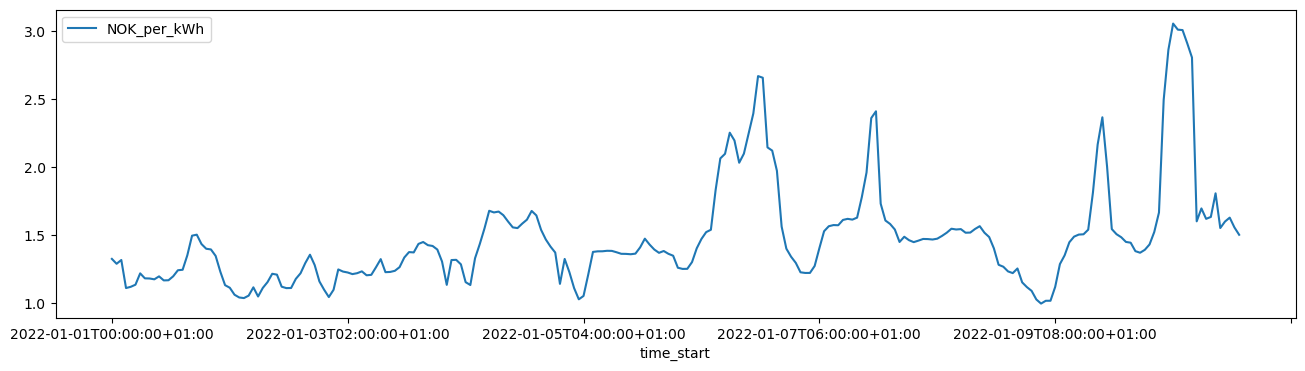

In [34]:
# Plot av strømprisene i de første 10 dager
df.iloc[0:240].plot(x='time_start', y='NOK_per_kWh', figsize=(16,4))
plt.savefig('strom_pris.png', dpi=500, bbox_inches='tight')
plt.show()

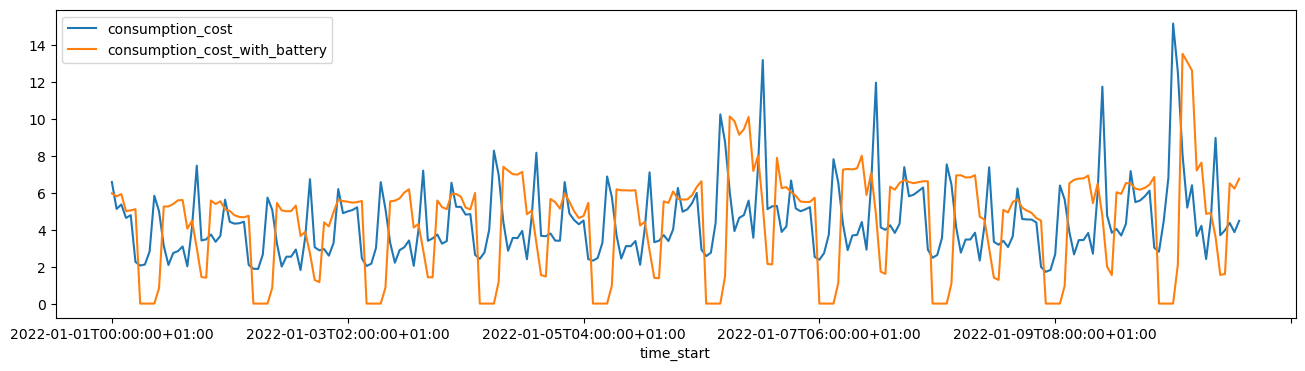

In [35]:
# Plot av strømforbruk de første 10 dager
df.iloc[0:240].plot(x='time_start', y=['consumption_cost', 'consumption_cost_with_battery'], figsize=(16,4))
plt.savefig('strom_bruk.png', dpi=500, bbox_inches='tight')
plt.show()